# **Check GPU**

In [26]:
!nvidia-smi

Mon Sep  2 14:32:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             28W /   70W |     291MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Requirements**

In [27]:
!pip install ultralytics

# **LIBRARIES & DEPENDENCIES**

In [28]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [29]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [62]:
# dataset_dir = f'{HOME}/vehicle-dataset-for-yolo/'
dataset_dir = '../input/vehicle-dataset-for-yolo/vehicle dataset/'
models_dir = f'{HOME}/models'
os.makedirs(models_dir, exist_ok=True)

# **Visualize Samples**

In [31]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [32]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [33]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

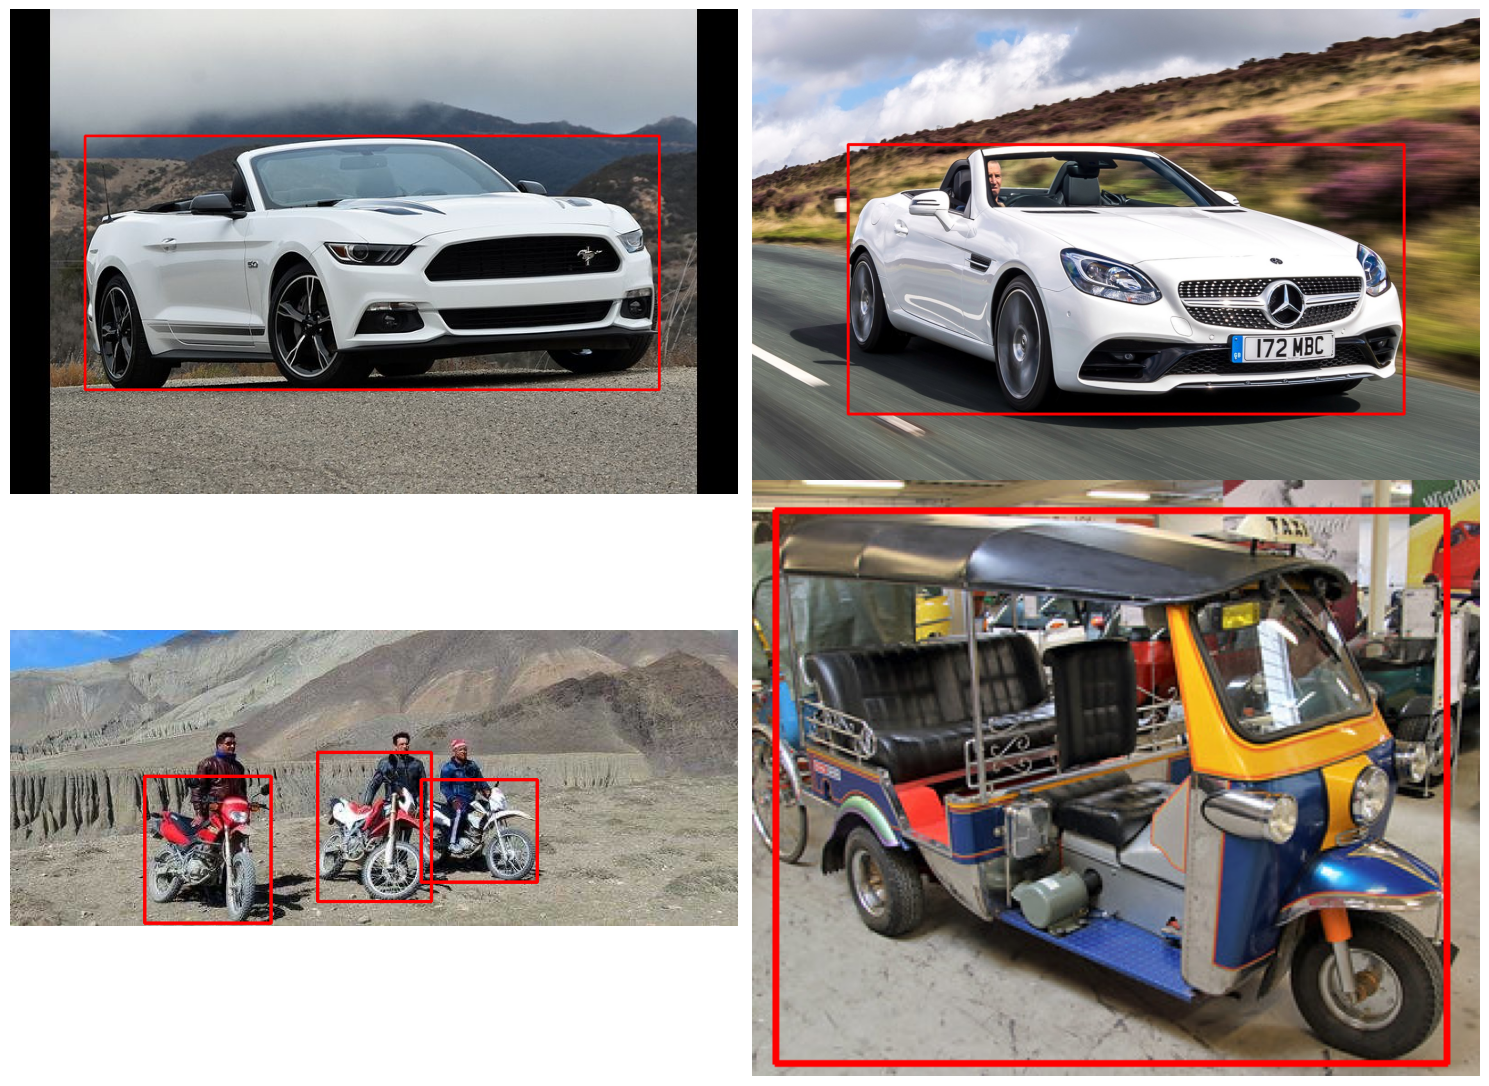

In [63]:
# Visualize a few training images.
plot(
    image_paths=f'{dataset_dir}/train/images/',
    label_paths=f'{dataset_dir}/train/labels/',
    num_samples=4,
)

# **YOLOv8-s**

In [43]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [44]:
modelS = YOLO(f"{models_dir}/yolov8s.pt")

WARNING ⚠️ 'source' is missing. Using 'source=/opt/conda/lib/python3.10/site-packages/ultralytics/assets'.



[ WARN:0@757.523] global loadsave.cpp:241 findDecoder imread_('C:\Users\Beso\Desktop\AI\check_model.jpg'): can't open/read file: check file path/integrity


image 1/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 45.1ms
image 2/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 45.8ms
Speed: 2.5ms preprocess, 45.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


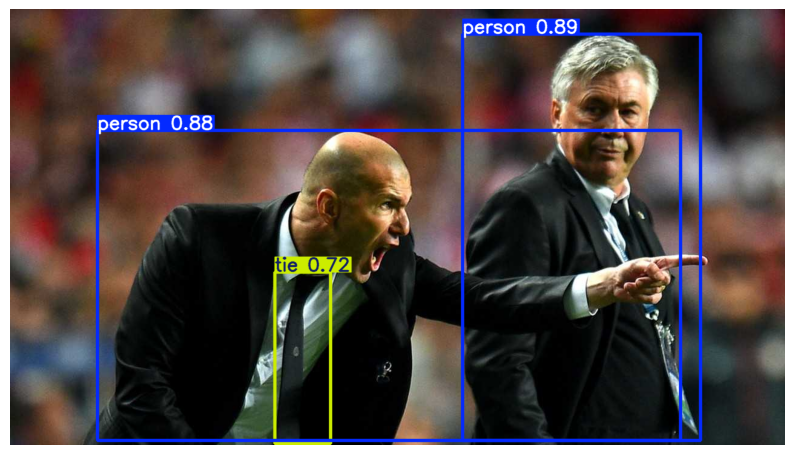

In [45]:
TEST_IMAGE_PATH = r"C:\Users\Beso\Desktop\AI\check_model.jpg"
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)
# TEST_IMAGE = cv2.resize(TEST_IMAGE, (640, 640))
CHECK_TEST_RESULT = modelS.predict(source=TEST_IMAGE, conf=0.5, save=False, imgsz=640)

plt.figure(figsize=(10, 10))
for result in CHECK_TEST_RESULT:
    plotted_image = result.plot()
    plotted_image_rgb = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(plotted_image_rgb)
    plt.axis('off')
plt.show()

# **Create YAML file**

In [52]:
yamlPath = f'{HOME}/data.yaml'

In [66]:
yamlContent = f"""
# path: '{dataset_dir}'
train: '../input/vehicle-dataset-for-yolo/vehicle dataset/train/images'
val: '../input/vehicle-dataset-for-yolo/vehicle dataset/train/images'

# class names
nc: 6
names:
  0: 'car'
  1: 'threewheel'
  2: 'bus'
  3: 'truck'
  4: 'motorbike'
  5: 'van'
"""

with open(f'{yamlPath}', 'w') as yaml:
    yaml.write(yamlContent)

# **Define Parameters**

In [54]:
EPOCHS = 20
IMAGE_SIZE = 640
BATCH = 32
NAME = 'yolov8s_cars'

# **Train Model [S]**

In [67]:
# Train Model
modelS.train(
    data=yamlPath,            # Path to the dataset configuration file
    epochs=EPOCHS,            # Number of epochs to train for
    imgsz=IMAGE_SIZE,         # Image size
    batch=BATCH,              # Batch size
    name=NAME                 # Name of the training run
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/models/yolov8s.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_cars5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-09-02 14:45:51,309	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-02 14:45:51,851	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 63.8MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:07<00:00, 283.84it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:02<00:00, 888.58it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8s_cars5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_cars5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.42G      2.376      3.858      2.336        100        640:  26%|██▌       | 17/66 [00:09<00:24,  2.02it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      7.42G      1.657      3.086      1.887         94        640:  77%|███████▋  | 51/66 [00:26<00:07,  2.02it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      7.42G      1.496      2.787       1.78         75        640: 100%|██████████| 66/66 [00:34<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:12<00:04,  2.07it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:12<00:03,  2.11it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]


                   all       2100       2685      0.611      0.607      0.672      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.67G     0.8053      1.445      1.308        102        640:  44%|████▍     | 29/66 [00:14<00:18,  2.00it/s]libpng warning: iCCP: known incorrect sRGB profile
       2/20      7.67G     0.7979      1.392      1.303        101        640:  62%|██████▏   | 41/66 [00:20<00:12,  2.02it/s]libpng warning: iCCP: known incorrect sRGB profile
       2/20      7.67G     0.7649      1.308      1.279         66        640: 100%|██████████| 66/66 [00:32<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:04,  2.22it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.21it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


                   all       2100       2685       0.83      0.802      0.892      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       7.7G     0.6727      1.035      1.203        118        640:  58%|█████▊    | 38/66 [00:18<00:13,  2.04it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20       7.7G     0.6887      1.045      1.211        115        640:  76%|███████▌  | 50/66 [00:24<00:07,  2.02it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20       7.7G     0.6882       1.03      1.205         62        640: 100%|██████████| 66/66 [00:32<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:04,  2.23it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.25it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


                   all       2100       2685      0.821      0.795      0.878      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.68G     0.6489     0.9262      1.177         90        640:  44%|████▍     | 29/66 [00:14<00:18,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
       4/20      7.68G     0.6423     0.9164      1.175         88        640:  52%|█████▏    | 34/66 [00:16<00:15,  2.04it/s]libpng warning: iCCP: known incorrect sRGB profile
       4/20      7.68G     0.6461     0.9006      1.179         60        640: 100%|██████████| 66/66 [00:32<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.27it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.19it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.11it/s]


                   all       2100       2685      0.906      0.873      0.945      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.68G     0.5962     0.7857      1.133        100        640:  20%|█▉        | 13/66 [00:06<00:27,  1.93it/s]libpng warning: iCCP: known incorrect sRGB profile
       5/20      7.68G      0.598     0.7712      1.126        122        640:  52%|█████▏    | 34/66 [00:17<00:16,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
       5/20      7.68G     0.5992     0.7604       1.13         58        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.29it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.31it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.14it/s]


                   all       2100       2685      0.876      0.854      0.936      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.68G     0.5933     0.7815      1.134        102        640:  17%|█▋        | 11/66 [00:05<00:27,  1.97it/s]libpng warning: iCCP: known incorrect sRGB profile
       6/20      7.68G     0.5713      0.723      1.119        102        640:  56%|█████▌    | 37/66 [00:18<00:14,  1.94it/s]libpng warning: iCCP: known incorrect sRGB profile
       6/20      7.68G     0.5799     0.7127      1.119         56        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.29it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.32it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.14it/s]

                   all       2100       2685      0.924      0.902       0.96      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.35G     0.5555     0.6408      1.102        112        640:  62%|██████▏   | 41/66 [00:20<00:12,  1.97it/s]libpng warning: iCCP: known incorrect sRGB profile
       7/20      7.35G     0.5469     0.6276      1.096        103        640:  89%|████████▉ | 59/66 [00:29<00:03,  1.95it/s]libpng warning: iCCP: known incorrect sRGB profile
       7/20      7.35G      0.548     0.6263      1.095         59        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.29it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.29it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.16it/s]

                   all       2100       2685      0.928      0.899      0.974      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.35G     0.5243     0.6074      1.072        107        640:  41%|████      | 27/66 [00:13<00:20,  1.95it/s]libpng warning: iCCP: known incorrect sRGB profile
       8/20      7.35G     0.5271     0.6009      1.073         89        640:  82%|████████▏ | 54/66 [00:27<00:06,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
       8/20      7.35G     0.5284     0.6019      1.075         76        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:04,  2.23it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.20it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.13it/s]

                   all       2100       2685       0.95      0.915      0.978       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.67G     0.5214     0.5791      1.074        105        640:  21%|██        | 14/66 [00:07<00:26,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      7.67G     0.5198     0.5571      1.067         99        640:  85%|████████▍ | 56/66 [00:28<00:05,  1.96it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      7.67G     0.5176     0.5557      1.066        104        640:  94%|█████████▍| 62/66 [00:31<00:02,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      7.67G     0.5177     0.5569      1.068         57        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.36it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.38it/s]libpng warning: i

                   all       2100       2685      0.909      0.928      0.962      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.68G     0.4768     0.5256      1.038        117        640:  76%|███████▌  | 50/66 [00:25<00:08,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      10/20      7.68G     0.4772     0.5218      1.036         78        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.30it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.32it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.11it/s]

                   all       2100       2685      0.956      0.944      0.988      0.917


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       7.7G      0.391       0.47     0.9801         39        640:  39%|███▉      | 26/66 [00:14<00:20,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20       7.7G     0.4002      0.475     0.9879         33        640:  44%|████▍     | 29/66 [00:15<00:18,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20       7.7G     0.4006     0.4654     0.9859         49        640:  94%|█████████▍| 62/66 [00:32<00:02,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20       7.7G      0.399     0.4626     0.9844         25        640: 100%|██████████| 66/66 [00:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.34it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.32it/s]libpng warning: i

                   all       2100       2685      0.942      0.926      0.983      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.67G     0.3762     0.4023     0.9687         42        640:  89%|████████▉ | 59/66 [00:29<00:03,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
      12/20      7.67G     0.3745     0.4008     0.9682         21        640: 100%|██████████| 66/66 [00:32<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:04,  2.17it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.21it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.13it/s]

                   all       2100       2685      0.972      0.956      0.988      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.67G      0.343     0.3117     0.8947         40        640:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]libpng warning: iCCP: known incorrect sRGB profile
      13/20      7.67G     0.3535     0.3649     0.9393         36        640:  68%|██████▊   | 45/66 [00:22<00:10,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      13/20      7.67G     0.3604     0.3699     0.9466         22        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.35it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.34it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]

                   all       2100       2685      0.984      0.965      0.991      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.66G     0.3398     0.3373     0.9186         43        640:  38%|███▊      | 25/66 [00:12<00:20,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      14/20      7.66G      0.337     0.3262     0.9292         47        640:  82%|████████▏ | 54/66 [00:27<00:06,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
      14/20      7.66G     0.3376     0.3243     0.9282         29        640: 100%|██████████| 66/66 [00:33<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.34it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.36it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.18it/s]

                   all       2100       2685      0.985      0.974      0.993      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.34G      0.292     0.2656     0.9583         33        640:   2%|▏         | 1/66 [00:00<00:34,  1.91it/s]libpng warning: iCCP: known incorrect sRGB profile
      15/20      7.34G     0.3071     0.2988     0.9134         40        640:  38%|███▊      | 25/66 [00:12<00:20,  1.96it/s]libpng warning: iCCP: known incorrect sRGB profile
      15/20      7.34G     0.3184     0.3006     0.9163         22        640: 100%|██████████| 66/66 [00:33<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:04,  2.25it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.20it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.14it/s]

                   all       2100       2685      0.984      0.977      0.993      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.34G     0.3142     0.2908       0.91         38        640:  48%|████▊     | 32/66 [00:15<00:16,  2.02it/s]libpng warning: iCCP: known incorrect sRGB profile
      16/20      7.34G     0.3165     0.2956     0.9083         50        640:  86%|████████▋ | 57/66 [00:28<00:04,  1.94it/s]libpng warning: iCCP: known incorrect sRGB profile
      16/20      7.34G      0.314     0.2973     0.9071         21        640: 100%|██████████| 66/66 [00:32<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.35it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:10<00:03,  2.39it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:14<00:00,  2.27it/s]

                   all       2100       2685      0.987      0.982      0.994      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.34G     0.2994     0.2791     0.8807         35        640:  21%|██        | 14/66 [00:07<00:25,  2.01it/s]libpng warning: iCCP: known incorrect sRGB profile
      17/20      7.34G      0.307     0.2783     0.9019         42        640:  56%|█████▌    | 37/66 [00:18<00:14,  1.98it/s]libpng warning: iCCP: known incorrect sRGB profile
      17/20      7.34G     0.3018      0.271     0.8997         35        640: 100%|██████████| 66/66 [00:33<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.26it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.25it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.20it/s]

                   all       2100       2685       0.99      0.985      0.994      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.34G     0.2958     0.2745     0.8888         37        640:  32%|███▏      | 21/66 [00:10<00:22,  1.99it/s]libpng warning: iCCP: known incorrect sRGB profile
      18/20      7.34G      0.292     0.2572     0.8966         48        640:  76%|███████▌  | 50/66 [00:25<00:08,  1.96it/s]libpng warning: iCCP: known incorrect sRGB profile
      18/20      7.34G     0.2853     0.2561     0.8977         20        640: 100%|██████████| 66/66 [00:33<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:10<00:03,  2.35it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:10<00:03,  2.36it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:14<00:00,  2.27it/s]

                   all       2100       2685      0.991      0.989      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.34G     0.2719      0.227     0.8753         42        640:   9%|▉         | 6/66 [00:03<00:29,  2.01it/s]libpng warning: iCCP: known incorrect sRGB profile
      19/20      7.34G     0.2627     0.2289     0.8777         35        640:  58%|█████▊    | 38/66 [00:19<00:14,  2.00it/s]libpng warning: iCCP: known incorrect sRGB profile
      19/20      7.34G      0.272     0.2359     0.8784         27        640: 100%|██████████| 66/66 [00:32<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.32it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.34it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.15it/s]

                   all       2100       2685      0.994      0.989      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.34G     0.3066     0.2458      0.939         37        640:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]libpng warning: iCCP: known incorrect sRGB profile
      20/20      7.34G      0.264     0.2179     0.8872         39        640:  24%|██▍       | 16/66 [00:07<00:24,  2.03it/s]libpng warning: iCCP: known incorrect sRGB profile
      20/20      7.34G     0.2698     0.2284     0.8759         28        640: 100%|██████████| 66/66 [00:32<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:11<00:03,  2.34it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:11<00:03,  2.33it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.17it/s]

                   all       2100       2685      0.995       0.99      0.995      0.967



20 epochs completed in 0.279 hours.
Optimizer stripped from runs/detect/yolov8s_cars5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_cars5/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_cars5/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 24/33 [00:13<00:04,  2.24it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 25/33 [00:13<00:03,  2.26it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:17<00:00,  1.90it/s]


                   all       2100       2685      0.995       0.99      0.995      0.967
                   car        408        461      0.993      0.983      0.995      0.973
            threewheel        352        482      0.994      0.992      0.995      0.965
                   bus        342        403      0.996      0.998      0.995      0.972
                 truck        381        478      0.994      0.998      0.995      0.968
             motorbike        373        483      0.996      0.979      0.995      0.931
                   van        358        378      0.996      0.992      0.995      0.991
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/yolov8s_cars5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7836c054cd30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

# **Evaluate Model**

In [68]:
evaluateCARS_Sval = modelS.val(
    data = yamlPath,
    split = 'val',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:02<00:00, 761.44it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-dataset-for-yolo/vehicle dataset/train is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  79%|███████▉  | 52/66 [00:19<00:04,  2.98it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 54/66 [00:19<00:04,  2.98it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:24<00:00,  2.75it/s]


                   all       2100       2685      0.995       0.99      0.995      0.967
                   car        408        461      0.993      0.982      0.995      0.974
            threewheel        352        482      0.994      0.992      0.995      0.966
                   bus        342        403      0.996      0.998      0.995      0.972
                 truck        381        478      0.994      0.998      0.995      0.967
             motorbike        373        483      0.996      0.979      0.995      0.933
                   van        358        378      0.994      0.992      0.995      0.991
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov8s_cars52


# **Download Model**

In [69]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

from IPython.display import FileLink
FileLink(r'runs.zip')

/kaggle/working/runs.zip

# **PLOTS**

In [70]:
from IPython.display import display, Image
from IPython import display
display.clear_output()

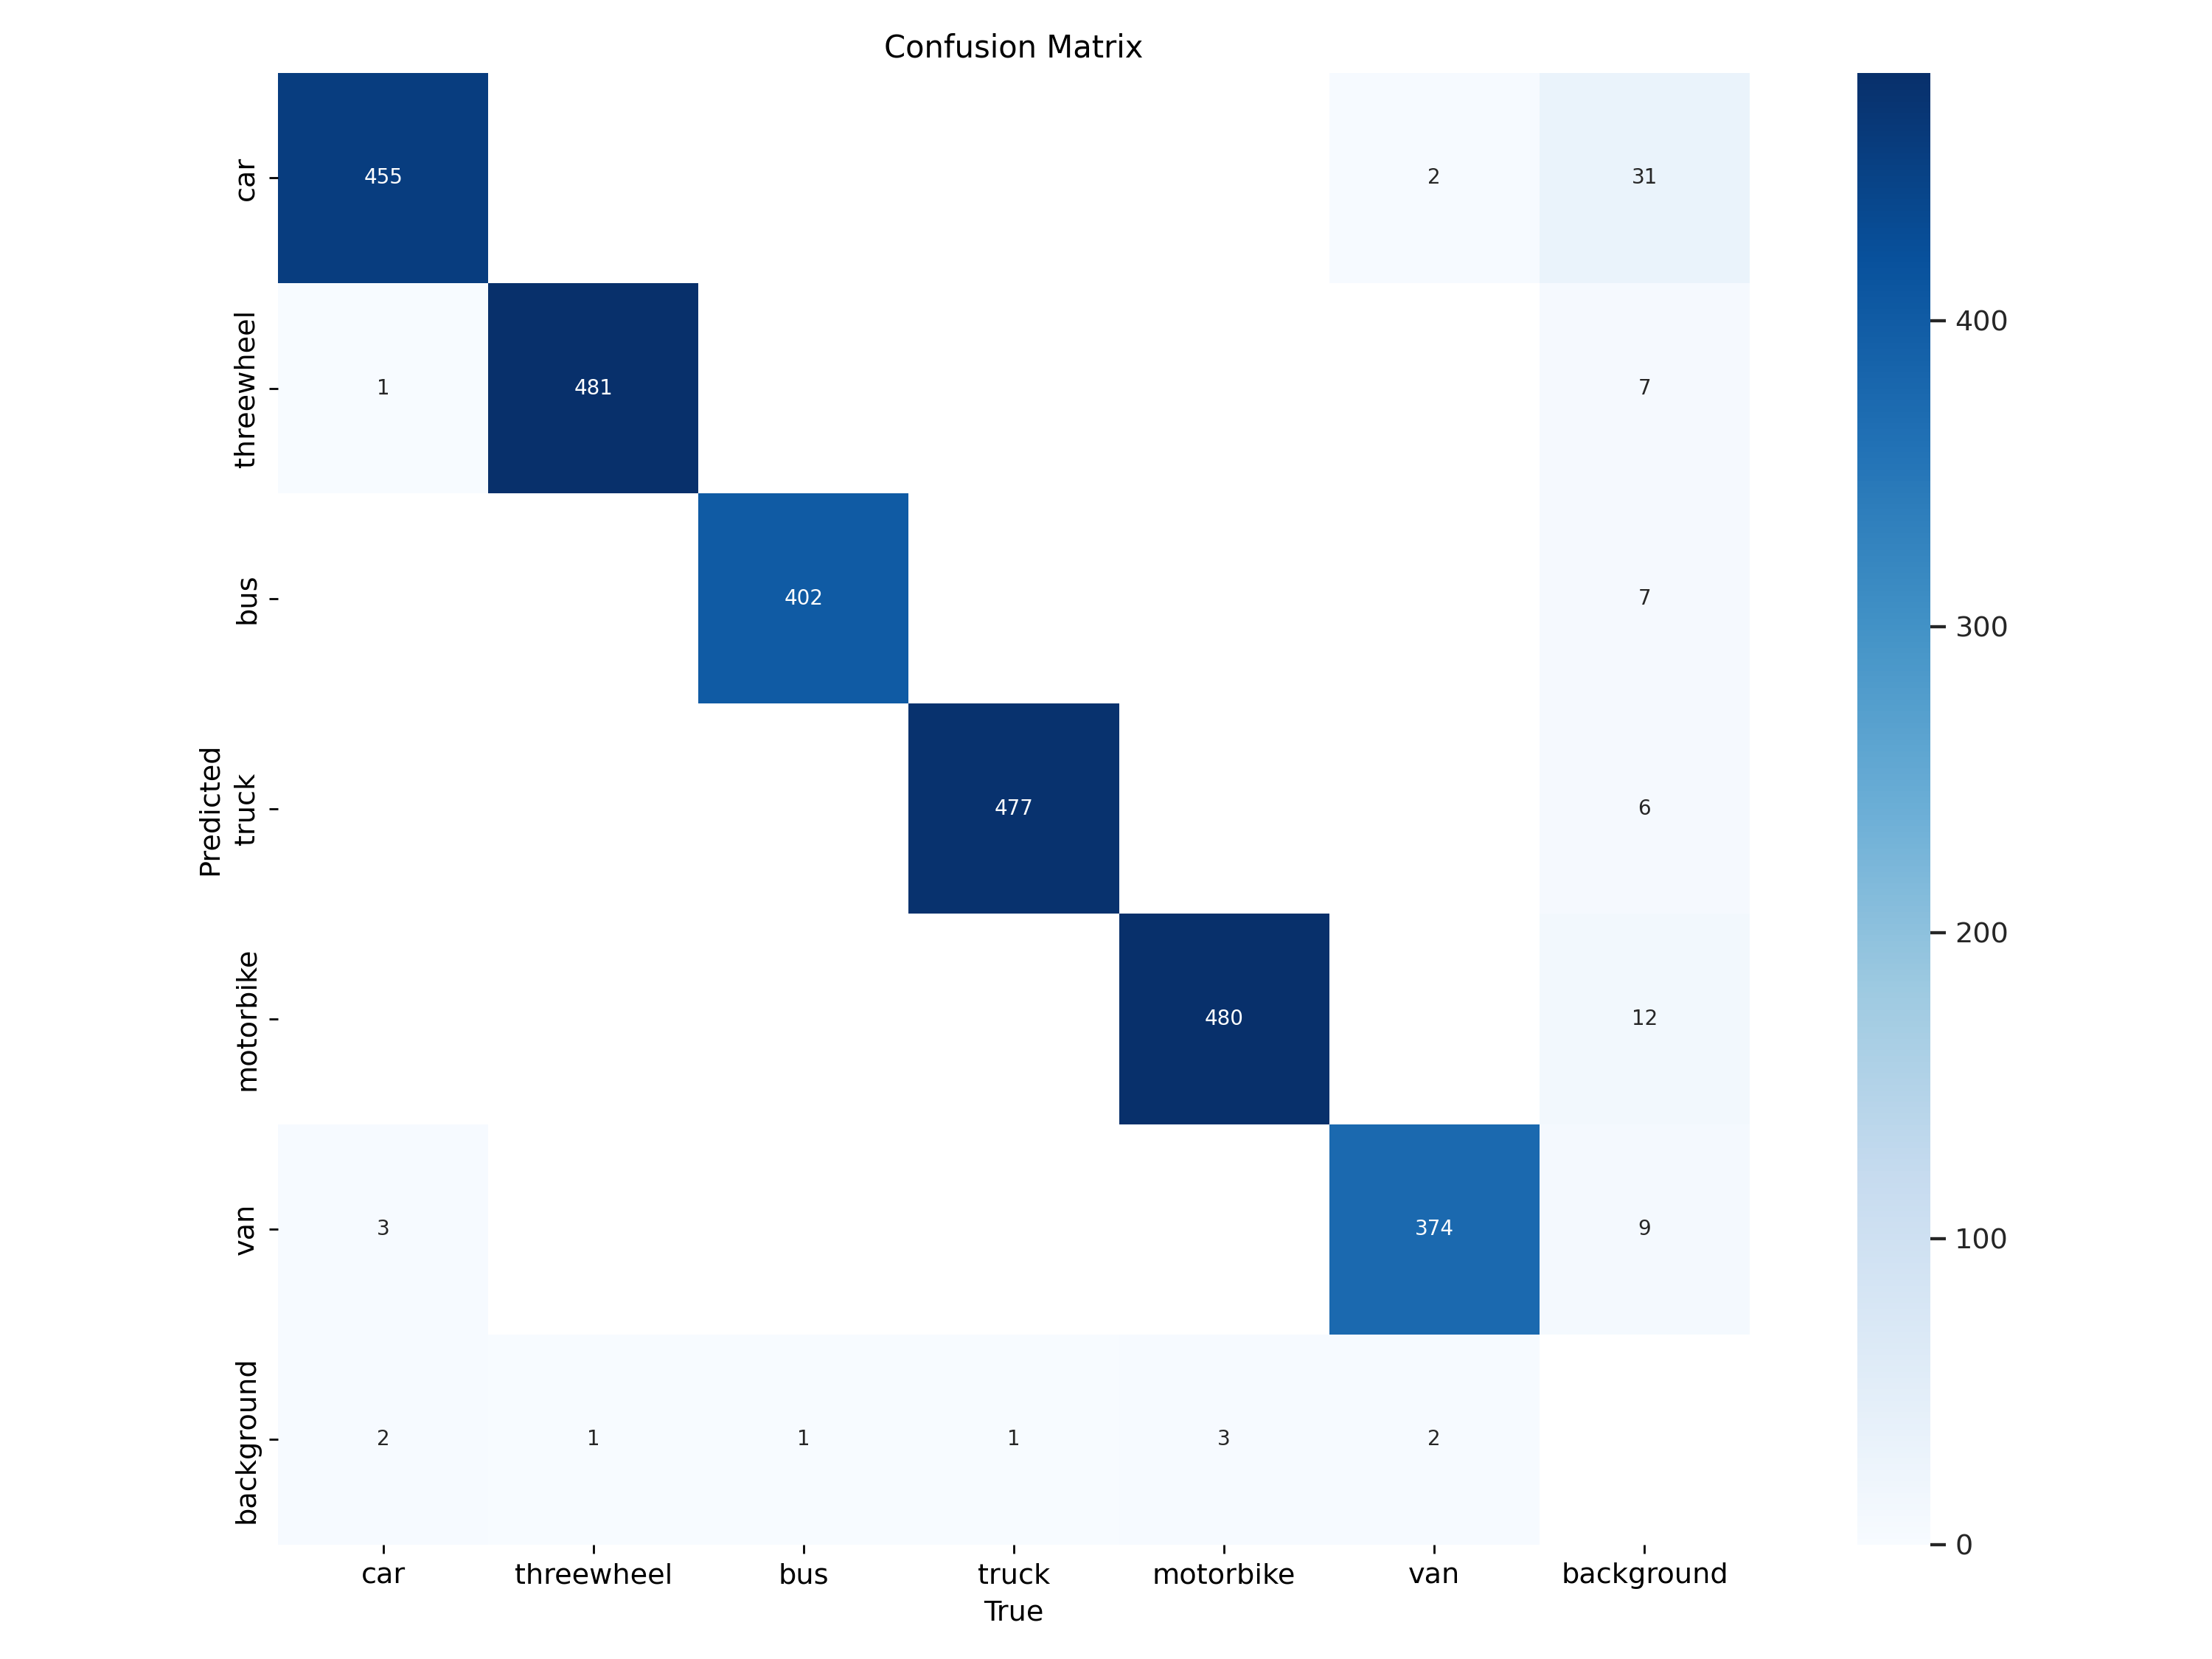

In [72]:
Image(filename=f'{HOME}/runs/detect/{NAME}5/confusion_matrix.png', width=600)

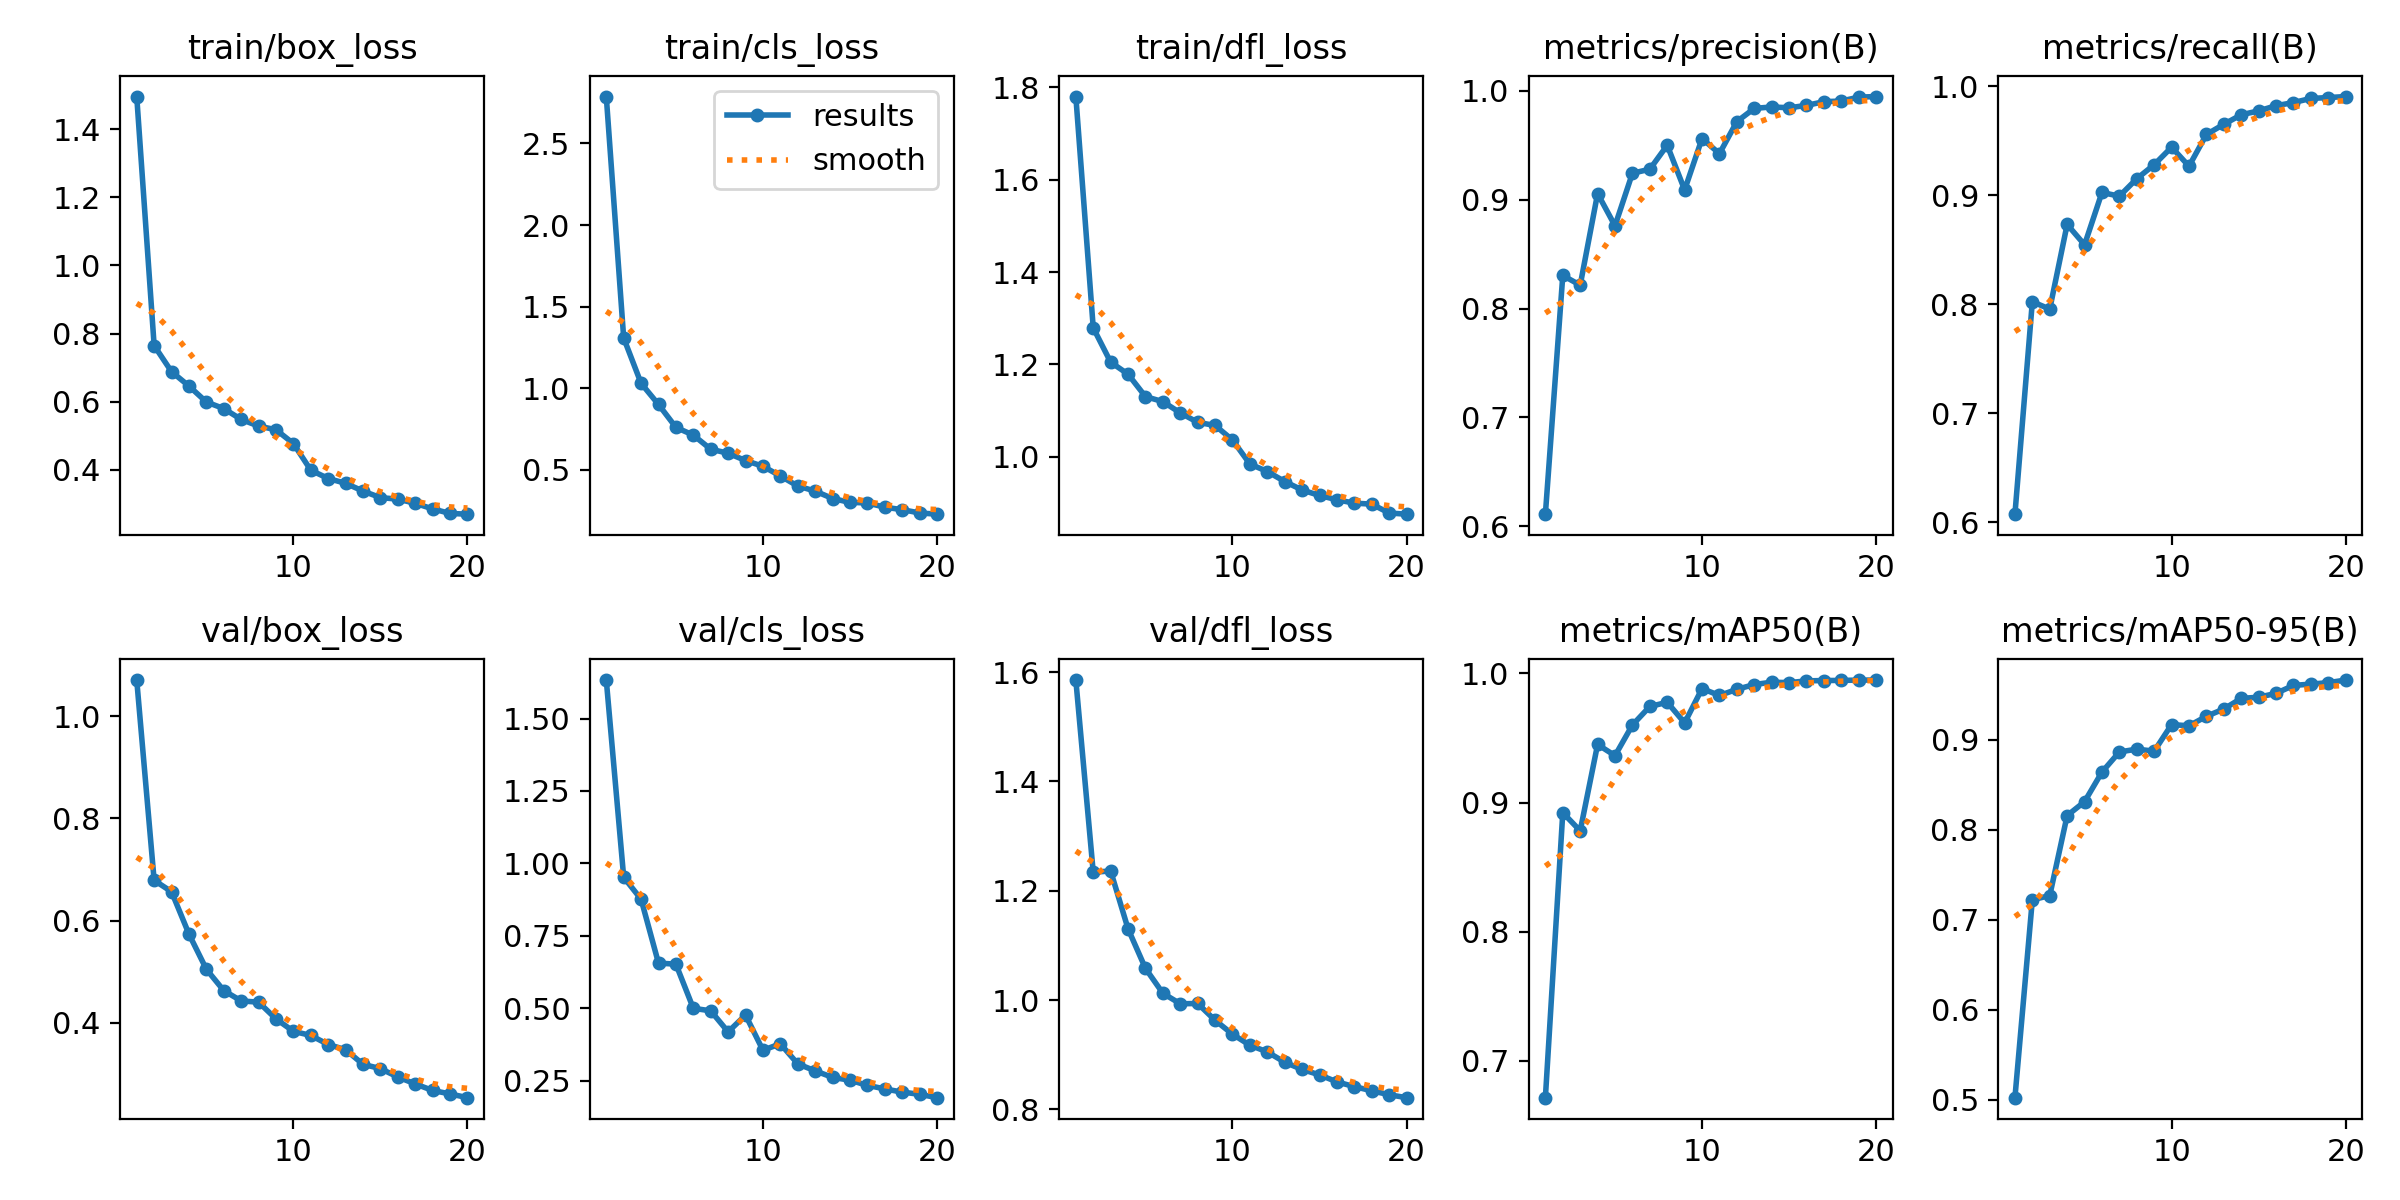

In [73]:
Image(filename=f'{HOME}/runs/detect/{NAME}5/results.png', width=600)

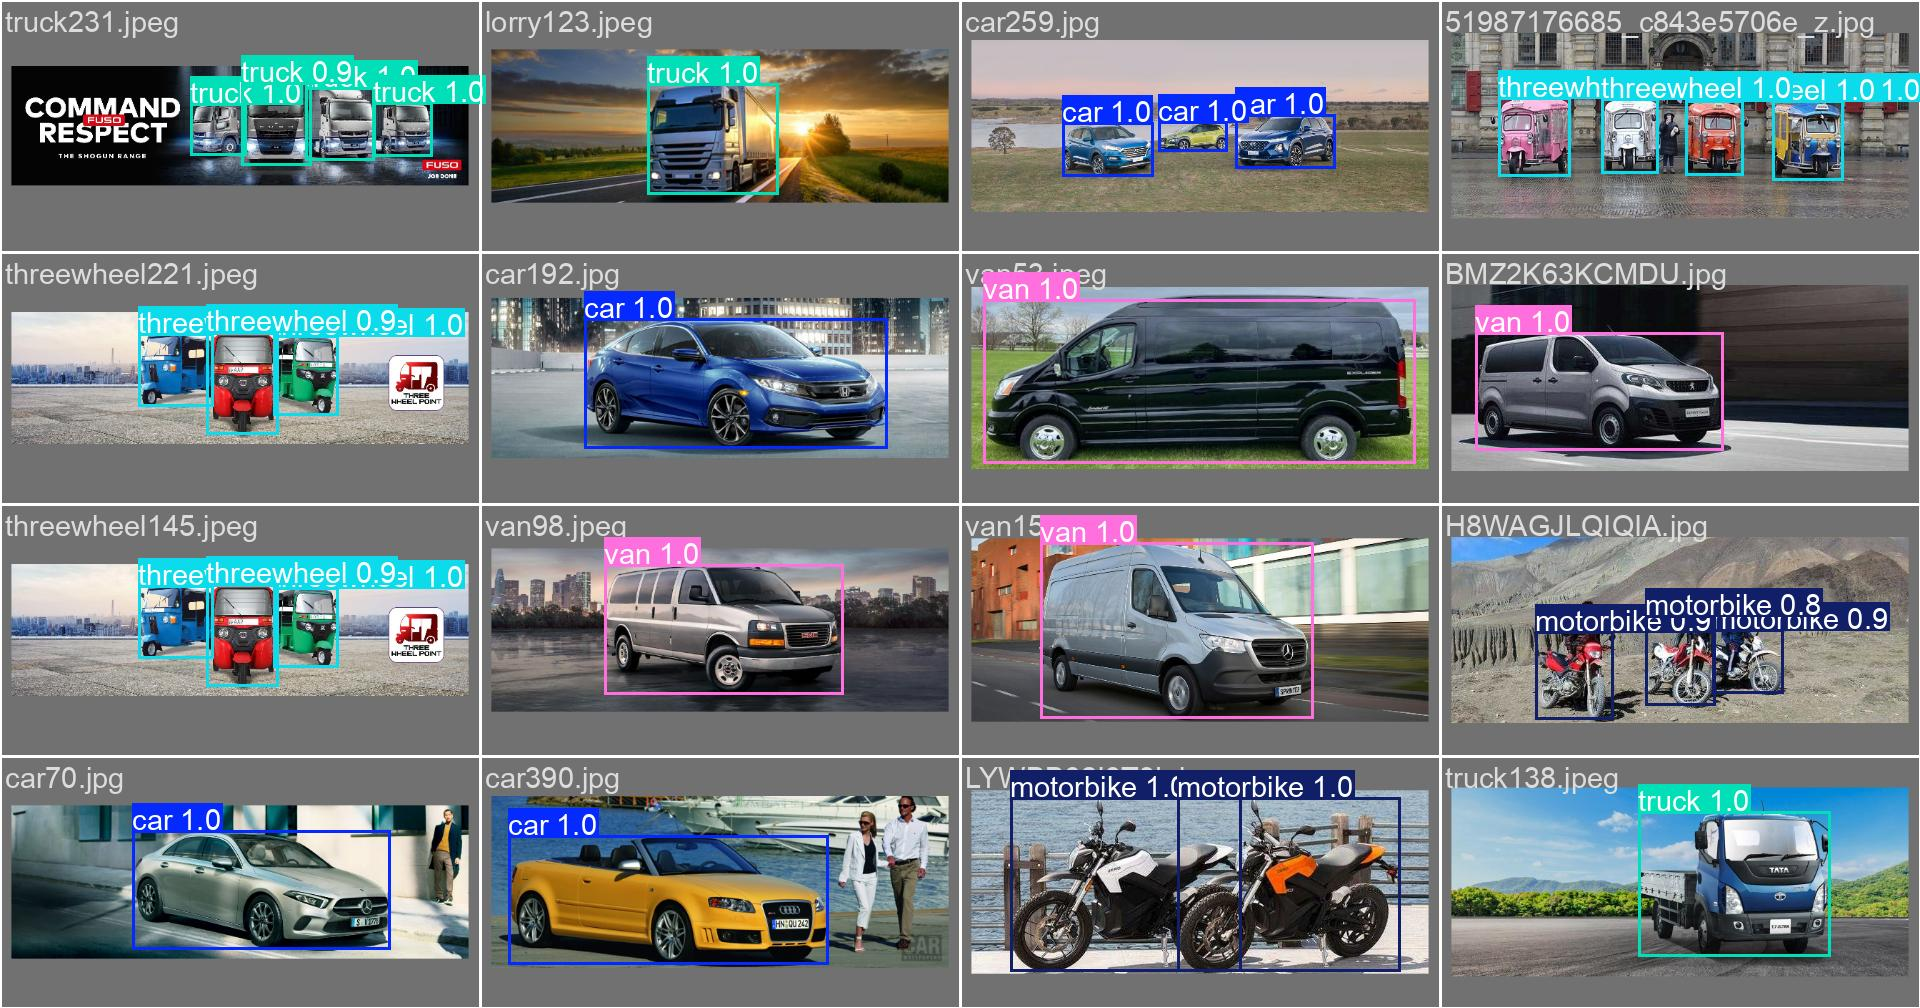

In [74]:
Image(filename=f'{HOME}/runs/detect/{NAME}5/val_batch0_pred.jpg', width=600)

# END

In [ ]:
os._exit(0)